# 모델 구현

# CNN으로 휠체어와 자전거 분류

In [ ]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms

#데이터 주소
train_data_path = "/content/drive/MyDrive/Dataset_CNN/train"
test_data_path = "/content/drive/MyDrive/Dataset_CNN/test"

#이미지 크기 20*20으로 변환
trans = transforms.Compose([transforms.Resize((20, 20)), transforms.ToTensor()])

#데이터셋 정의
Baby_train_data = torchvision.datasets.ImageFolder(root = train_data_path, transform = trans)
Baby_test_data = torchvision.datasets.ImageFolder(root = test_data_path, transform = trans)

#train 데이터셋을 train과 validation 데이터셋으로 나눠줌(7:3 비율)
train_size = int(0.7 * len(Baby_train_data))
valid_size = len(Baby_train_data) - train_size

train_data, valid_data = torch.utils.data.random_split(Baby_train_data, [train_size, valid_size])

#배치 사이즈 조정을 위한 데이터로더 
train_loader = torch.utils.data.DataLoader(Baby_train_data, batch_size= 100, shuffle= True)
test_loader = torch.utils.data.DataLoader(Baby_test_data, batch_size= 100, shuffle= False)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size= 100, shuffle= True)

print('data ready~')

#GPU 연산
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print(DEVICE)

data ready~
cuda


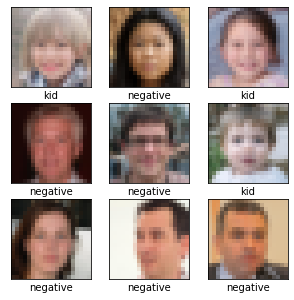

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

#train 데이터셋 이미지 출력
class_names = Baby_train_data.classes
sample_size = 9
random_idx = np.random.randint(len(train_data), size=sample_size)

plt.figure(figsize = (5, 5))
for i, idx in enumerate(random_idx):
  plt.subplot(3, 3, i+1)
  plt.xticks([])
  plt.yticks([])
  img, label = train_data[idx]
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.xlabel(class_names[label])
plt.show()

In [ ]:
#import
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init

In [ ]:
#하이퍼파라미터 설정
learning_rate = 0.001
training_epochs = 10

In [ ]:
#모델 구성
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.keep_prob = 0.5 #드롭아웃 비율 0.5


        #레이어 하나당 합성곱, ReLU, MaxPool 순으로 지나감
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))


        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1))

        self.fc1 = torch.nn.Linear(3 * 3 * 128, 625, bias=True)
        torch.nn.init.xavier_uniform_(self.fc1.weight) #가중치 초기화

        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=1 - self.keep_prob)) #드롭아웃


        self.fc2 = torch.nn.Linear(625, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight)

    #연산순서
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.layer4(out)
        out = self.fc2(out)
        return out

In [ ]:
#CNN 인스턴스 생성
model = CNN().to(DEVICE)

In [ ]:
#비용 함수로는 CrossEntropy, optimization함수로는 Adam을 사용합니다.
criterion = torch.nn.CrossEntropyLoss().to(DEVICE)    # 비용 함수에 소프트맥스 함수 포함되어져 있음
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
total_batch = len(train_loader)
print('총 배치의 수 : {}'.format(total_batch))

총 배치의 수 : 84


In [ ]:
#훈련

for epoch in range(training_epochs):
    avg_cost = 0
    accuracy = np.array([])

    for X, Y in train_loader: # 미니 배치 단위로 꺼내온다. X는 미니 배치, Y는 레이블.

        X = X.to(DEVICE)
        Y = Y.to(DEVICE)

        optimizer.zero_grad() #optimizer 초기화
        hypothesis = model(X) #입력 데이터를 생성한 model에 넣어줌
        cost = criterion(hypothesis, Y) #output로 cost값 계산
        cost.backward()
        optimizer.step()

        pred = np.argmax(hypothesis.cpu().detach().numpy(), axis = 1) #모델이 추측한 답
        ans = Y.cpu().numpy() #실제 라벨값

        accuracy = np.append(accuracy, np.equal(pred, ans)) #모델이 추측한 답과 실제 라벨값의 유사도를 비교

        #cost 값 누적
        avg_cost += cost / total_batch

    #cost 출력
    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

[Epoch:    1] cost = 0.627369642
[Epoch:    2] cost = 0.303071737
[Epoch:    3] cost = 0.209734797
[Epoch:    4] cost = 0.172480866
[Epoch:    5] cost = 0.155386865
[Epoch:    6] cost = 0.137778267
[Epoch:    7] cost = 0.128076151
[Epoch:    8] cost = 0.11256329
[Epoch:    9] cost = 0.104604937
[Epoch:   10] cost = 0.0986585319


In [ ]:
with torch.no_grad():
    X = X.to(DEVICE)
    Y = Y.to(DEVICE)

    pred = np.argmax(hypothesis.cpu().detach().numpy(), axis = 1)
    ans = Y.cpu().numpy()

    accuracy = np.append(accuracy, np.equal(pred,ans))

    print('acc', '{:.4f}'.format(np.mean(accuracy))) #정확도의 평균을 출력

acc 0.9666


In [ ]:
model.eval() # test시에는 dropout을 꺼준다.
correct = 0
total = 0

for image, label in test_loader:
  x = image.to(torch.device('cuda'))
  y_ = label.to(torch.device('cuda'))

  output = model.forward(x)
  _, output_index = torch.max(output,1) # output을 인덱스 1방향으로 최고를 뽑아줌
  total += label.size(0)
  correct += (output_index == y_).sum().float()

print('Acc : {}'.format(100*correct/total))

Acc : 94.52777862548828


In [ ]:
import random 

cmap_lst = plt.cm.rainbow

with torch.no_grad():
  r = random.randint(1, len(y_)-1)
  single_x = x[r:r+1].to(DEVICE)
  single_y = y_[r:r+1].to(DEVICE)
  prediction = model(single_x)
  print('실제 값:', single_y.item())
  print('예측 값:', torch.argmax(prediction,1).item())
  #plt.imshow(test_loader.test_data[r:r + 1].view(28, 28), cmap='Greys', interpolation='nearest')
  #plt.show()


실제 값: 1
예측 값: 1


In [ ]:
torch.save(model, '/content/drive/MyDrive/PeaceLoveFree.pth')

In [ ]:
model = torch.load('/content/drive/MyDrive/PeaceLoveFree.pth')

In [ ]:
test_data_path = "/content/drive/MyDrive/ho/test"


Baby_test_data = torchvision.datasets.ImageFolder(root = test_data_path, transform = trans)


test_loader = torch.utils.data.DataLoader(Baby_test_data, batch_size= 100, shuffle= False)

In [ ]:
model.eval() # test시에는 dropout을 꺼준다.
correct = 0
total = 0

for image, label in test_loader:
  x = image.to(torch.device('cuda'))
  y_ = label.to(torch.device('cuda'))

  output = model.forward(x)
  _, output_index = torch.max(output,1) # output을 인덱스 1방향으로 최고를 뽑아줌
  total += label.size(0)
  correct += (output_index == y_).sum().float()

print('Acc : {}'.format(100*correct/total))

Acc : 80.0
